In [1]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# %%bash
# cd ../../pipelines/research-mhqa-evaluation/
# mv experiment-results.json experiment-results.json.bak
# dvc exp show -n 3 --json > experiment-results.json

In [3]:
with open('../../pipelines/research-mhqa-evaluation/experiment-results.json') as f:
    data = json.load(f)

In [4]:
def parse_params(record):
    params_node = record.get("data", {}).get("params", {})
    params = {}
    for k, v in params_node.items():
        params.update(v.get("data", {}))
    return params

def parse_metrics(record):
    metrics_node = record.get("data", {}).get("metrics", {})
    metrics = {}
    for k, v in metrics_node.items():
        metrics.update(v.get("data", {}))
    return metrics

def parse_experiment(record):
    return {
        'id': record['rev'],
        'name': record['name'],
        'params': parse_params(record),
        'metrics': parse_metrics(record),
    }


def parse_experiments(data):
    for node in data:
        if node.get("error"):
            continue
        commit = node.get("rev")
        if experiments := (node.get('experiments') or []):
            for experiment in experiments:
                for rev in (experiment.get('revs') or []):
                    if not rev.get("error"):
                        yield {"commit": commit, **parse_experiment(rev)}
        else:
            yield {"commit": commit, **parse_experiment(node)}

In [5]:
experiments = list(parse_experiments(data))
print(f"{len(experiments)} experiments")
experiments[0]

133 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique-2hop',
   'name': 'answerable',
   'split': 'validation'},
  'qa': {'prompt': 'standard', 'model': 'llama-3-70b-tgi', 'temperature': 0.7},
  'run': 1},
 'metrics': {'exact_match': 0.5, 'f1': 0.6599999999999999, 'fuzzy_match': 0.7}}

In [6]:
valid_experiments = [
    experiment
    for experiment in experiments
    if experiment["params"].get("qa")
]
len(valid_experiments)

103

In [7]:
df = (
    pd.json_normalize(valid_experiments)
    .sort_values(["params.qa.model", "params.qa.prompt", "params.qa.temperature", "params.run"])
    .drop(columns=["commit", "id", "params.dataset.subset"])
)
dataset_path = "bdsaglam/musique"
mask = (df["params.dataset.path"] == dataset_path) & (df["params.dataset.split"] == "validation")
df = df.loc[mask].reset_index(drop=True)
df.drop_duplicates(inplace=True)
df

,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.prompt,params.qa.model,params.qa.temperature,params.run,metrics.exact_match,metrics.f1,metrics.fuzzy_match
0,heapy-rick,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,0.1,1,0.371949,0.440146,0.416632
1,chief-holy,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,0.5,1,0.362019,0.429637,0.408357
2,lowse-sack,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,0.5,3,0.372362,0.439525,0.415391
3,rimed-jots,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,0.7,1,0.364501,0.437996,0.415805
4,honey-wise,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,0.7,3,0.373190,0.443116,0.414977
5,zesty-tamp,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,1.0,1,0.352917,0.421768,0.396359
6,regal-tirl,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,1.0,3,0.366570,0.434349,0.412909
7,metal-yack,bdsaglam/musique,answerable,validation,cot-zs,llama-3-70b-tgi,0.1,1,0.359950,0.433857,0.404220
8,lunar-jaws,bdsaglam/musique,answerable,validation,cot-zs,llama-3-70b-tgi,0.1,3,0.360778,0.434446,0.405048
9,piano-adze,bdsaglam/musique,answerable,validation,cot-zs,llama-3-70b-tgi,0.5,1,0.359950,0.432583,0.404634


In [8]:
metric_cols = [col for col in df.columns if col.startswith("metrics.")]

In [9]:
df.drop(
    columns=["name", "params.dataset.path", "params.dataset.name", "params.dataset.split", "params.qa.model"]
).groupby(["params.qa.prompt", "params.qa.temperature"]).aggregate(["mean", "max", "count"]).loc[:, metric_cols]

metrics.exact_match                  \
                                                      mean       max count   
params.qa.prompt params.qa.temperature                                       
cot-fs           0.1                              0.371949  0.371949     1   
                 0.5                              0.367191  0.372362     2   
                 0.7                              0.368846  0.373190     2   
                 1.0                              0.359743  0.366570     2   
cot-zs           0.1                              0.360364  0.360778     2   
                 0.5                              0.364088  0.368225     2   
                 0.7                              0.356227  0.357882     2   
                 1.0                              0.341332  0.341746     2   
cte              0.1                              0.636740  0.638395     2   
                 0.5                              0.632396  0.632602     2   
                 0.7                              0.636740  0.639222     2   
                 1.0                              0.622466  0.622673     2   
standard         0.1                              0.543401  0.544063     5   
                 0.5                              0.537526  0.541167     5   
                 0.7                              0.535650  0.536202     3   
                 1.0                              0.524410  0.525859     2   

                                       metrics.f1                  \
                                             mean       max count   
params.qa.prompt params.qa.temperature                              
cot-fs           0.1                     0.440146  0.440146     1   
                 0.5                     0.434581  0.439525     2   
                 0.7                     0.440556  0.443116     2   
                 1.0                     0.428058  0.434349     2   
cot-zs           0.1                     0.434152  0.434446     2   
                 0.5                     0.437747  0.442912     2   
                 0.7                     0.430623  0.432154     2   
                 1.0                     0.413651  0.414486     2   
cte              0.1                     0.742344  0.743800     2   
                 0.5                     0.739527  0.739682     2   
                 0.7                     0.739766  0.742647     2   
                 1.0                     0.734463  0.734591     2   
standard         0.1                     0.651896  0.652452     5   
                 0.5                     0.649063  0.650146     5   
                 0.7                     0.647801  0.648529     3   
                 1.0                     0.639766  0.641445     2   

                                       metrics.fuzzy_match                  
                                                      mean       max count  
params.qa.prompt params.qa.temperature                                      
cot-fs           0.1                              0.416632  0.416632     1  
                 0.5                              0.411874  0.415391     2  
                 0.7                              0.415391  0.415805     2  
                 1.0                              0.404634  0.412909     2  
cot-zs           0.1                              0.404634  0.405048     2  
                 0.5                              0.406289  0.407944     2  
                 0.7                              0.398635  0.398842     2  
                 1.0                              0.385602  0.388498     2  
cte              0.1                              0.693215  0.694249     2  
                 0.5                              0.689491  0.689698     2  
                 0.7                              0.690732  0.692594     2  
                 1.0                              0.679561  0.681010     2  
standard         0.1                              0.607530  0.609847     5  
            

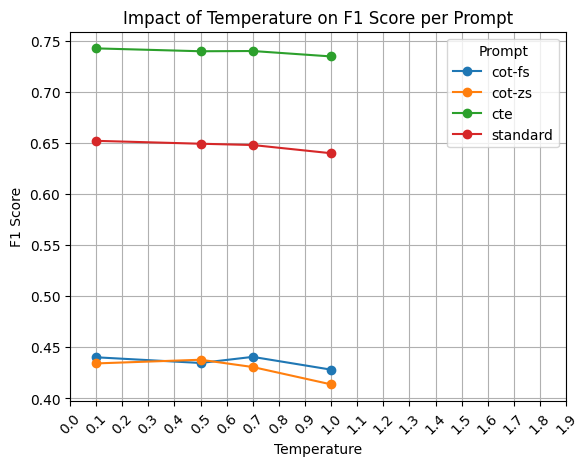

In [10]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(["params.qa.prompt", "params.qa.temperature"])[
        ["metrics.exact_match", "metrics.f1", "metrics.fuzzy_match"]
    ]
    .mean()
    .reset_index()
)

# Plotting the impact of temperature per prompt
prompts = df_avg["params.qa.prompt"].unique()

for prompt in prompts:
    subset = df_avg[df_avg["params.qa.prompt"] == prompt]
    plt.plot(subset["params.qa.temperature"], subset["metrics.f1"], marker="o", label=prompt)

plt.xlabel("Temperature")
plt.ylabel("F1 Score")
plt.title("Impact of Temperature on F1 Score per Prompt")
plt.legend(title="Prompt")
plt.xticks(ticks=list(np.arange(0, 2, 0.1)), rotation=45)  # Adding xticks for temperature values in range(0, 2, 0.1)
plt.grid(True)
plt.show()

In [11]:
# To compare the prompts at the best temperature
# Assuming "best temperature" is defined as the one with the highest average F1 score
df_best_temp = (
    df_avg.loc[df_avg.groupby("params.qa.prompt")["metrics.f1"].idxmax()]
    .set_index("params.qa.prompt", drop=False)
    .loc[["standard", "cot-zs", "cot-fs", "cte"]]
    .copy()
)
df_best_temp

,params.qa.prompt,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.fuzzy_match
params.qa.prompt,,,,,
standard,standard,0.1,0.543401,0.651896,0.607530
cot-zs,cot-zs,0.5,0.364088,0.437747,0.406289
cot-fs,cot-fs,0.7,0.368846,0.440556,0.415391
cte,cte,0.1,0.636740,0.742344,0.693215


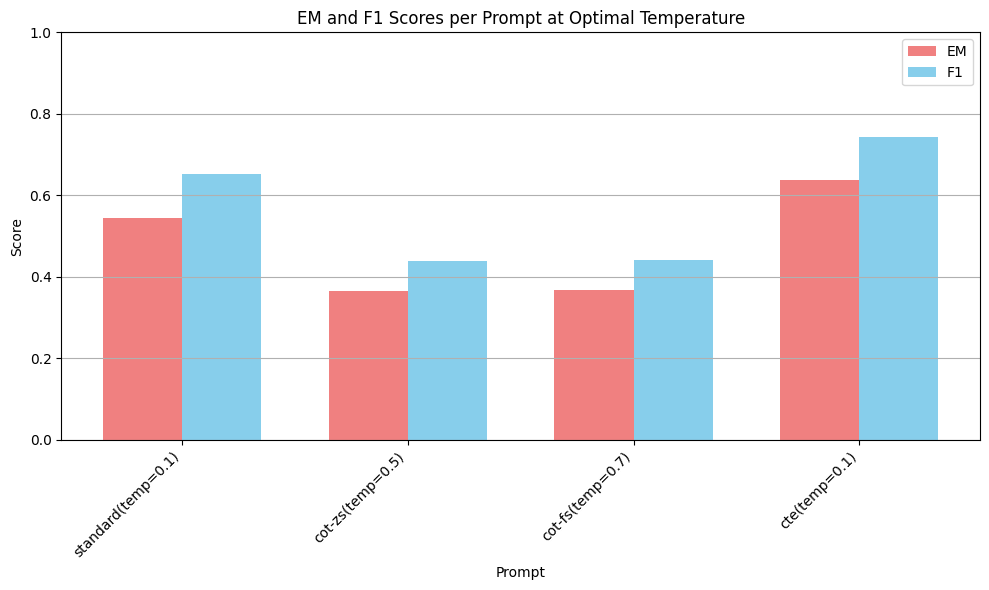

In [12]:
# Plotting EM and F1 scores together per prompt with temperature annotations
plt.figure(figsize=(10, 6))

# Create x-tick labels that include both the prompt and temperature
xs = [
    f"{prompt}(temp={temperature})"
    for prompt, temperature in zip(
        df_best_temp["params.qa.prompt"].values, df_best_temp["params.qa.temperature"].values
    )
]

# Set the width for the bars and the positions
bar_width = 0.35
index = np.arange(len(xs))

# Plot Exact Match (EM) bars
bar1 = plt.bar(index, df_best_temp["metrics.exact_match"], bar_width, label="EM", color="lightcoral")

# Plot F1 bars, shifted by bar_width for side-by-side bars
bar2 = plt.bar(index + bar_width, df_best_temp["metrics.f1"], bar_width, label="F1", color="skyblue")

# Add labels and titles
plt.xlabel('Prompt')
plt.ylabel('Score')
plt.title('EM and F1 Scores per Prompt at Optimal Temperature')

# Set x-ticks with prompt and temperature labels
plt.xticks(index + bar_width / 2, xs, rotation=45, ha='right')

# Add a legend to differentiate between EM and F1 scores
plt.legend()

# Add a grid and display the plot
plt.grid(axis='y')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

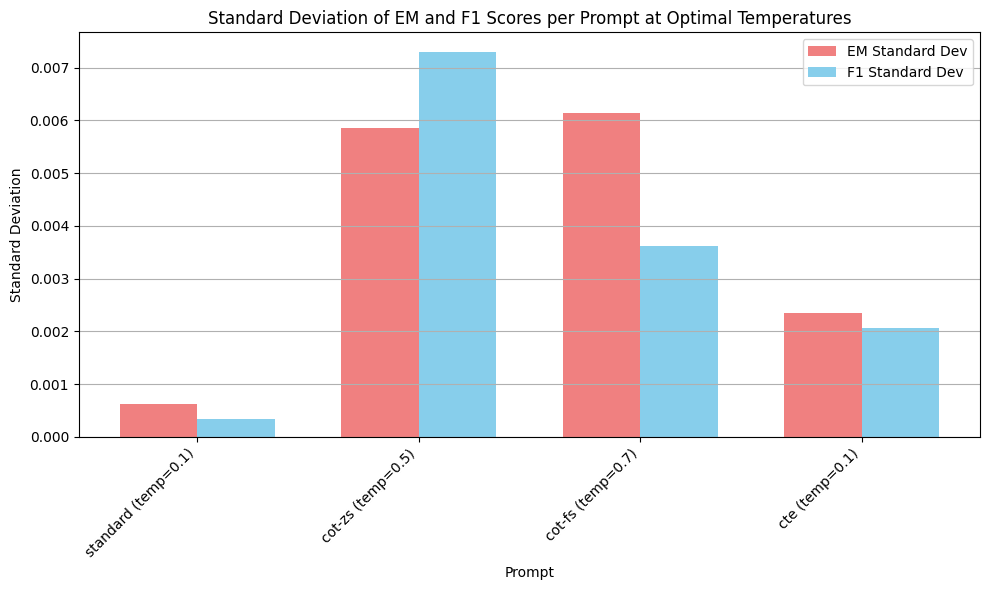

In [13]:
# Initialize an empty list to store stats
stats = []

# Loop through each prompt and its optimal temperature
for index, row in df_best_temp.iterrows():
    prompt = row['params.qa.prompt']
    optimal_temp = row['params.qa.temperature']
    
    # Select rows that correspond to the current prompt and its optimal temperature
    df_temp = df[(df['params.qa.prompt'] == prompt) & (df['params.qa.temperature'] == optimal_temp)]
    
    # Calculate stats for Exact Match and F1 scores
    em_std = df_temp['metrics.exact_match'].std()
    f1_std = df_temp['metrics.f1'].std()
    
    # Append to the list
    stats.append({
        'prompt': prompt,
        'optimal_temp': optimal_temp,
        'EM.std': em_std,
        'F1.std': f1_std
    })

# Convert the stats to a DataFrame
df_stats = pd.DataFrame(stats).set_index('prompt', drop=False).loc[['standard', 'cot-zs', 'cot-fs', 'cte']].copy()

# Combine prompt and optimal temperature for xticks
df_stats['prompt_with_temp'] = df_stats['prompt'] + " (temp=" + df_stats['optimal_temp'].astype(str) + ")"

# Plotting the stats of EM and F1 scores for each prompt
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for EM stats
bar_width = 0.35
index = np.arange(len(df_stats))

bar1 = ax.bar(index, df_stats['EM.std'], bar_width, label='EM Standard Dev', color='lightcoral')

# Bar plot for F1 stats, offset by bar_width for side-by-side bars
bar2 = ax.bar(index + bar_width, df_stats['F1.std'], bar_width, label='F1 Standard Dev', color='skyblue')

# Add labels and titles
ax.set_xlabel('Prompt')
ax.set_ylabel('Standard Deviation')
ax.set_title('Standard Deviation of EM and F1 Scores per Prompt at Optimal Temperatures')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_stats['prompt_with_temp'], rotation=45, ha='right')
ax.legend()

# Add a grid and display the plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()
